In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute,QuantumRegister, ClassicalRegister
from numpy.random import randint
from numpy import pi
from time import time
import scipy as sc
import scipy.linalg as la
import json
import math as math
import warnings
warnings.filterwarnings('ignore')


# define noise model for simulation; note the version of qiskit
#from qiskit_aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error, coherent_unitary_error,phase_damping_error
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error, coherent_unitary_error,phase_damping_error
from scipy.optimize import curve_fit, minimize
from qiskit.quantum_info import process_fidelity, PTM, diamond_norm

def unitary_error_rx(theta):  #exp(-i theta/2 X)
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])

def unitary_error_rz(theta):  #exp(-i theta/2 Z)
    return np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

def unitary_error_ry(theta):  #exp(-i theta/2 Y)
    return np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])

# generate noise model; 'ps': probability of stochastic noise; 'angle': angle of unitary error; 'axis': the axis of unitary error
def get_noise_model(ps=0.001,angle=0.01,axis='z'):
    noise_model=NoiseModel()
    
    error_ad= amplitude_damping_error(ps)
    error_pd= phase_damping_error(ps)
    error_st= error_pd.compose(error_ad)
    
    if axis=='z':
        error_u_mat= unitary_error_rz(angle)
    elif axis=='x':
        error_u_mat= unitary_error_rx(angle)
    else:
        error_u_mat= unitary_error_ry(angle)
    
    error_u = coherent_unitary_error(error_u_mat)
    
    error_1q= error_u.compose(error_st)
    noise_model.add_all_qubit_quantum_error(error_1q, ['t','h','u1','u2','u3','I','X','Y','Z','ry','rz','rx'])
    
    
    return noise_model,error_1q

# simulate circuits with given noise model
def noise_sim(circ_list,noise_model,shots=8192):
    result = execute(circ_list, backend=Aer.get_backend('qasm_simulator'),noise_model=noise_model, shots=shots,optimization_level=0).result()
    count_list=[result.get_counts(circ) for circ in circ_list]
    exp_list=[count.get('0',0)/shots for count in count_list]
    
    return exp_list

# actual process infidelity and stochastic infidelity of noise 
def act_error(error_1q,target_mat):
    pf= process_fidelity(error_1q)
    noisy_gate=error_1q.compose(coherent_unitary_error(target_mat))
    ptm=PTM(noisy_gate)
    evals, evecs=np.linalg.eig(ptm)
    stof= np.sqrt(np.mean(np.square(np.abs(evals))))
    
    return 1-pf, 1-stof


#define matrix pencil data processing technique; this code is from the paper [spectral quantum tomography] with some modifications.
def matrix_pencil(time_series_data,L ,N_poles,cutoff=10**(-10)):
        """Computes a decomposition into exponentially decaying oscillations of a given time series.
        Input: time_series_data: a list of floats corresponding to the state of the system at fixed time intervals.
                NOTE: It is important this timeseries starts at t=0 (k=0), the method as implemented can't deal with timeshifts and may fail quietly
               L: A matrix pencil parameter. Set between 1/2 and 2/3 of len(time_series_data) 
               N_poles: The number of poles the data can be decomposed into. Choosing this number too small will lead to bad fits so act with care.
               cutoff: a cut-off for the smallest possible relative amplitude a poles can contribute with, standard is 10^(-2). Here we set it to a very low value,because we know the num of poels.
        Ouput: poles: a scipy array of the poles (the oscillating bits).
                amplitudes: a scipy array of amplitudes corresponding to the poles.
                
                """      
        #Compute the length of the data series and store it in N
        N = len(time_series_data)
       
        #Compute the Hankel matrix of the data
        Y = sc.matrix([time_series_data[i:L+i+1] for i in range(0,N-L)]) 
        
        #Take the singular value decomposition of the data Hankel matrix
        U,S,Vh = sc.linalg.svd(Y) 
        Vh =sc.matrix(Vh)
        U = sc.matrix(U)
        if S[2]/S[3]>10: # if the third singular value is ten times larger than the fourth, set the N_poles=3
            N_poles=3       
        #The ESPRIT method includes a filter step that gets rid of small singular values.
        # Since for us the number of poles is known I just retain the N_poles largest singular values and corresponding right eigenspace.
        #If N_poles is so large that it starts to include nonsense values we let the cutoff parameter set the number of relevant poles instead.
        #We choose to retain only the singular values s such that s>s_max * cutoff where s_max is the largest singualr value
        Scutoff = S[S>cutoff*S[0]]
        if len(Scutoff)<N_poles:

            Sprime = sc.matrix([[S[i] if i==j else 0 for i in range(len(Scutoff))] for j in range(N-L)])
            Vhprime = Vh[0:len(Scutoff),:]
        else:
            Sprime = sc.matrix([[S[i] if i==j else 0 for i in range(N_poles)] for j in range(N-L)])
            Vhprime = Vh[0:N_poles,:]
        
        #Compute the shifted matrices for the matrix pencil.
        Vhprime1 = Vhprime[:,0:-1]
        Vhprime2 = Vhprime[:,1:]
        
        #Compute the solution of the matrix pencil (via SVD)
        Y = la.pinv(Vhprime1.H)*Vhprime2.H
        poles, vecs = sc.linalg.eig(Y)
        for i in range(len(poles)):
            amp= np.abs(poles[i])
            if amp>1:
                poles[i]= poles[i]/amp
        
        #Compute the amplitudes by least squares optimization
        Z = sc.matrix([poles**k for k in range(N)])
        amplitudes = la.lstsq(Z,sc.matrix(time_series_data).transpose())
        ampls = sc.array([a[0] for a in amplitudes[0]])
        amp_max= np.max(np.abs(ampls))
        
        poles_p=[]
        ampls_p=[]
        for i in range(len(poles)):
            if np.abs(ampls[i])/amp_max>0.05:  # discard the poles with very small amplitudes
                poles_p.append(poles[i])
                ampls_p.append(ampls[i])
                
        #return the poles and amplitudes as scipy arrays
        return poles_p, ampls_p,amplitudes,S

# process the poles from matrix_pencil method to obtain 'process infidelity', 'sotchastic infidelity', and rotational angle error
def result_mp(poles,target_phase=0.25*pi,rep=1):
    if len(poles)<4:
        poles= np.append(poles,1)
    amp= np.abs(poles)
    target_phase_p= (target_phase*rep)%(2*pi)
    if target_phase_p-pi> 10**-4:
        target_phase_p= target_phase_p-2*pi
    phase= np.angle(poles)
    phase_dif= np.abs(phase-target_phase_p)
    angle_index= np.argmin(phase_dif)
    angle_error= (phase-target_phase_p)[angle_index]        
    phase_dif2= np.abs(np.abs(phase)-np.abs(target_phase_p))
    index_com= np.argwhere(phase_dif2>np.abs(angle_error))

    res=[]
    angle_error= angle_error/rep
    if np.abs(np.abs(target_phase)-pi)<10**-4:
        angle_error= np.abs(angle_error)   # if rotational angle of target gate is pi, this method only gives the magnitude of angle error
    res.append(angle_error)
    res.append((amp[angle_index])**(1/rep))
    for i in index_com:
        res.append((amp[i[0]])**(1/rep))
    r= 1-(0.5*res[1]*np.cos(res[0])+0.25*(res[2]+res[3]))
    u= 1-np.sqrt((2*res[1]**2+res[2]**2+res[3]**2)/4)
    return [r,u, angle_error], res


class Csb_q1rotation:
      #'rot_angle': rotaion angle of target gate; 'rot_axis':rotational axis
    def __init__(self, rot_angle= pi/4, rot_axis='z'):   
        self.rot_angle = rot_angle
        self.axis = rot_axis
        self.phase = rot_angle
    
    # 'len_list': the list of circuit length; 'ini_mode': the inital state; 'rep':the number of repeats of the target gate
    def benchmark_circ(self,len_list,ini_mode='x',rep=1):
        circ_list=[]
        for lc in len_list:
            qc= QuantumCircuit(1,1)
            if ini_mode=='x':
                qc.h(0)
            elif ini_mode=='y':
                qc.h(0)
                qc.s(0)
            elif ini_mode=='z':
                qc.x(0)
            qc.barrier()
            
            for k in range(lc*rep):
                if self.axis=='x':
                    qc.rx(self.rot_angle,0)
                elif self.axis=='y':
                    qc.ry(self.rot_angle,0)
                if self.axis=='z':
                    qc.rz(self.rot_angle,0)
            qc.barrier()

            if ini_mode=='x':
                qc.h(0)
            elif ini_mode=='y':
                qc.sdg(0)
                qc.h(0)
            elif ini_mode=='z':
                qc.x(0)
            qc.barrier()
            qc.measure(0,0)
            circ_list.append(qc)
        return circ_list
    
    # the full list of circuits for CSB;
    # 'len_max': the maximum length of the list of circuits; 'rep': the number of repeats of the target gate
    def full_circs(self,len_max=50,rep=1):
        self.rep= rep
        if self.axis=='x':
            mode_list=['z','x']
        elif self.axis=='y':
            mode_list=['z','y']
        elif self.axis =='z':
            mode_list= ['x','z']
    
        len_list=[i for i in range(0,len_max+1)]
        circs_list=[]
        for mode in mode_list:
            circs_list = circs_list+ self.benchmark_circ(len_list,ini_mode=mode,rep=rep)
        return circs_list
    
    # input: the list of measured probabilities of circuits;
    # output: [process infidelity, stochastic infidelity, angle error]; diagonal entries of the pure noise channel
    def result(self,data):
        target_phase=self.phase
        data1,data2= np.split(np.array(data),2)
        data_com= data1+ data2
        len_data= len(data_com)
        
        poles, amps,amplitudes,S = matrix_pencil(data_com,L= math.ceil(len_data*3/5),N_poles=4,cutoff=10**-10)
        results,spec = result_mp(poles,target_phase= target_phase, rep= self.rep)
        
        return results, spec
    
    # the function doing numerical simulation
    def simulation(self,noise_model,len_max=50,shots=10**4,rep=1):
        circs=self.full_circs(len_max=len_max,rep=rep)
        data=[]
        data=noise_sim(circs,noise_model=noise_model,shots=shots)
            
        res,spec=self.result(data)
        return res, spec,data

In [2]:
# simulation of t gate under varying stochastic noise and fixed unitary error
ts=time()
ps_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[7 for i in range(5)]+ [1 for i in range(4)]  # if ps<=0.01, rep=7 (other values are also ok but should avoid channel phase=0 or pi and amplify unitary error too much); otherwise, rep=1; 
L_max=50  # 50 is enough, but one can increase 'L_max' further to gain more accuracy
shots=10**4
act_error_list=[]
est_sto=[]
target_mat= unitary_error_rz(pi/4)

for i,ps in enumerate(ps_list):
    noise_model,error_1q= get_noise_model(ps=ps,angle=-0.01,axis='z')
    act_error_list.append(act_error(error_1q,target_mat=target_mat))
    
    for k in range(10):
        csb_t= Csb_q1rotation(rot_angle=pi/4,rot_axis='z')
        res,spec,data=csb_t.simulation(noise_model=noise_model,len_max=L_max,shots=shots,rep=rep_list[i])
        est_sto.append(res)
te=time()
print('time cost=',te-ts)

time cost= 339.5860595703125


In [3]:
print(est_sto)

[[0.0006817229499302968, 0.0006566876729316995, -0.009995371020426422], [0.0006772544503532707, 0.0006519004600855638, -0.01005938733591175], [0.0006847511682530616, 0.0006596662279341192, -0.010005080367233006], [0.0006937583907915545, 0.0006686491542179374, -0.01000927810980696], [0.0006908221696402261, 0.0006658685646686591, -0.009978571281419466], [0.0006904369613733863, 0.0006655844401791677, -0.00995820310850951], [0.0006573449556084299, 0.0006320270204319689, -0.010053323392912523], [0.0006896301265387761, 0.000664485721650343, -0.010016757004698553], [0.0007095669568397689, 0.000684465807872292, -0.010006772370487813], [0.0006531455567436728, 0.0006279330009013595, -0.010032505353337186], [0.0013423299557502322, 0.0013171018130394563, -0.009985233310701225], [0.001356811144567871, 0.001331378840502384, -0.010024630024419747], [0.0013399508277714967, 0.001314922326217438, -0.009945475814874752], [0.0013311742328288023, 0.0013057423144300362, -0.010028096081642393], [0.0013073894

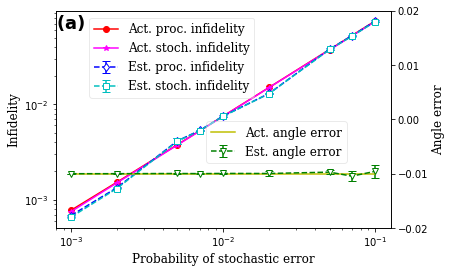

In [4]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Probability of stochastic error',fontdict={'family':'serif', 'size':12})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':12})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,np.array(act_error_list)[:,0],'r',marker='o',ls='-',label='Act. proc. infidelity')
ax1.plot(ps_list,np.array(act_error_list)[:,1],'magenta',marker='*',ls='-',label='Act. stoch. infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Est. proc. infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Est. stoch. infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.6), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':12})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[-0.01 for i in range(9)],'y',label='Act. angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='Est. angle error',color='g')

ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.45,0.3), prop={'family':'serif', 'size':12},fontsize=12)


# Adding title
# Show plot
plt.show()

In [5]:
np.array(list(map(np.mean,np.split(np.array(est_sto)[:,0],9))))-np.array(act_error_list)[:,0]

array([-9.21314233e-05, -1.89126881e-04,  3.62044079e-04,  4.48016814e-05,
        1.39696397e-05, -2.03701755e-03,  3.29016394e-04, -3.25453059e-04,
       -2.97031825e-04])

In [6]:
ts=time()
angle_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[7 for i in range(9)]  # for very weak noise, the more precision needed, which can be achieved by increasing the length of the circuits
L_max=100    # increasing length can be achieved by increasing L_max (also equal to the num of circuits) or increasing 'rep' (the num of target is repeated each time applied; if unitary noise is too strong, 'rep' should be small, otherwise may causing misidentification of eigenvalues)
shots=10**4
act_uni_error_list=[]
est_uni=[]
data_list=[]
target_mat= unitary_error_rz(pi/4)

for i,angle in enumerate(angle_list):
    noise_model,error_1q= get_noise_model(ps=0.001,angle=angle,axis='z')
    act_uni_error_list.append(act_error(error_1q,target_mat=target_mat))
    for k in range(10):
        csb_t= Csb_q1rotation(rot_angle=pi/4,rot_axis='z')
        res,spec,data=csb_t.simulation(noise_model=noise_model,len_max=L_max,shots=shots,rep=rep_list[i])
        est_uni.append(res)
        data_list.append(data)
te=time()
print('time cost=',te-ts)

time cost= 1044.1404657363892


In [7]:
print(est_uni)

[[0.0006613770399874763, 0.0006610336864818489, 0.001009533705236503], [0.0006486648224512948, 0.0006483318442194186, 0.0009977642978758233], [0.000641106151364923, 0.0006407828021133266, 0.0009843341944026282], [0.0006513438240426384, 0.000651006377974217, 0.0010059557815418024], [0.0006509051048180226, 0.0006505639901158711, 0.001013486482130288], [0.0006539116074557594, 0.000653579854161257, 0.0009917302264560288], [0.000641123327745019, 0.0006407922842314173, 0.0009984679213596184], [0.0006471040545334983, 0.0006467835021461976, 0.0009747604259516818], [0.0006513680488862139, 0.0006510214248445223, 0.001023056559566011], [0.0006499851428011238, 0.0006496534481819083, 0.0009945606393416049], [0.0006478394866614723, 0.0006467389696468429, 0.0020175627309109317], [0.0006515378204590139, 0.0006504683722425852, 0.001985284843329906], [0.0006621680824927534, 0.00066107058807785, 0.0020096817626885644], [0.0006353597038144532, 0.0006342719628488203, 0.0020094987953394516], [0.000658562679

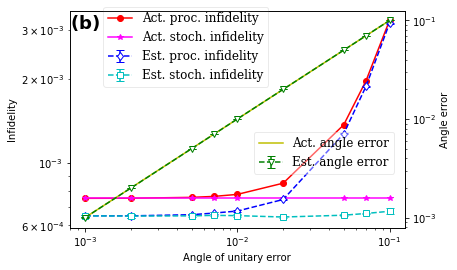

In [9]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Angle of unitary error')
ax1.set_ylabel('Infidelity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,np.array(act_uni_error_list)[:,0],'r',marker='o',ls='-',label='Act. proc. infidelity')
ax1.plot(angle_list,np.array(act_uni_error_list)[:,1],'magenta',marker='*',ls='-',label='Act. stoch. infidelity')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Est. proc. infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Est. stoch. infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.65), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(angle_list,angle_list,'y',label='Act. angle error')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='Est. angle error',color='g')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

# Adding title
# Show plot
#plt.savefig()
plt.show()

In [10]:
print(np.array(list(map(np.mean,np.split(np.array(est_uni)[:,0],9))))-np.array(act_uni_error_list)[:,0])

[-1.00560838e-04 -1.01496756e-04 -1.00571832e-04 -9.77931608e-05
 -9.92657271e-05 -1.06734450e-04 -9.73628280e-05 -8.80679429e-05
 -7.30137130e-05]


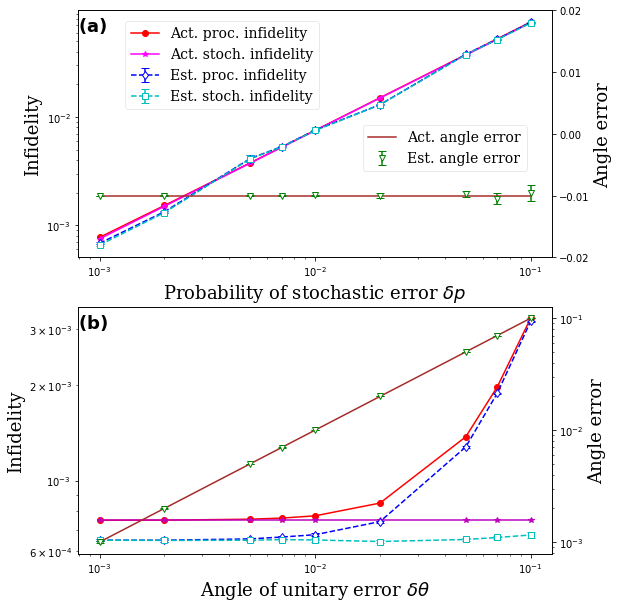

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 10)
# Creating plot with dataset_1
ax1=plt.subplot(2,1,1)
 

ax1.set_xlabel(r'Probability of stochastic error $\delta p$',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,np.array(act_error_list)[:,0],'r',marker='o',ls='-',label='Act. proc. infidelity')
ax1.plot(ps_list,np.array(act_error_list)[:,1],'magenta',marker='*',ls='-',label='Act. stoch. infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Est. proc. infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Est. stoch. infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.6), prop={'family':'serif', 'size':14},fontsize=16)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[-0.01 for i in range(9)],'brown',label='Act. angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Est. angle error',color='g')

ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.6,0.35), prop={'family':'serif', 'size':14},fontsize=16)


# Creating plot with dataset_2
ax1=plt.subplot(2,1,2)
ax1.set_xlabel(r'Angle of unitary error $\delta \theta$',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,np.array(act_uni_error_list)[:,0],'r',marker='o',ls='-',label='Act. proc. infidelity')
ax1.plot(angle_list,np.array(act_uni_error_list)[:,1],'m',marker='*',ls='-',label='Act. stoch. infidelity')
ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Est. proc. infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Est. stoch. infidelity',color='c')

ax1.tick_params(axis ='y')
#ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.plot(angle_list,angle_list,'brown',label='Act. angle error')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Est. angle error',color='g')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
#ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

fig.subplots_adjust(hspace=0.2)
plt.savefig('csb_tg.pdf')
plt.show()

In [2]:
ts=time()
ps_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[25,25]+[15 for i in range(3)]+[3 for i in range(4)]
L_max_list=[100 for i in range(5)]+[50 for i in range(4)]
shots=10**4
act_error_list=[]
est_sto=[]
for i,ps in enumerate(ps_list):
    noise_model,error_1q= get_noise_model(ps=ps,angle=0.01,axis='x')
    act_error_list.append(act_error(error_1q))
    
    for k in range(10):
        csb_x= Csb_q1rotation(rot_angle=pi,rot_axis='x')
        res,spec,data=csb_x.simulation(noise_model=noise_model,len_max=L_max_list[i],shots=shots,rep=rep_list[i])
        est_sto.append(res)
te=time()
print('time cost=',te-ts)

time cost= 1357.673700094223


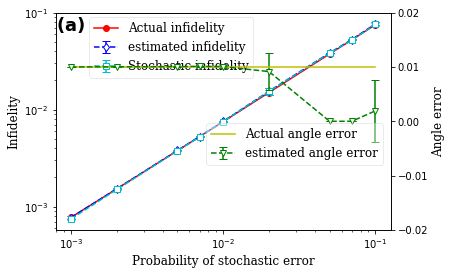

In [3]:

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Probability of stochastic error',fontdict={'family':'serif', 'size':12})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':12})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,act_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='estimated infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':12})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[0.01 for i in range(9)],'y',label='Actual angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='estimated angle error',color='g')

ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.45,0.3), prop={'family':'serif', 'size':12},fontsize=12)


# Adding title
# Show plot
plt.show()

In [4]:
ts=time()
angle_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[25 for i in range(9)]  # for very weak noise, the more precision needed, which can be achieved by increasing the length of the circuits
L_max=100   # increasing length can be achieved by increasing L_max (also equal to the num of circuits) or increasing 'rep' (the num of target is repeated each time applied; if unitary noise is too strong, 'rep' should be small, otherwise may causing misidentification of eigenvalues)
shots=10**4
act_uni_error_list=[]
est_uni=[]
data_list=[]
for i,angle in enumerate(angle_list):
    noise_model,error_1q= get_noise_model(ps=0.001,angle=angle,axis='x')
    act_uni_error_list.append(act_error(error_1q))
    for k in range(10):
        csb_x= Csb_q1rotation(rot_angle=pi,rot_axis='x')
        res,spec,data=csb_x.simulation(noise_model=noise_model,len_max=L_max,shots=shots,rep=rep_list[i])
        est_uni.append(res)
        data_list.append(data)
te=time()
print('time cost=',te-ts)

time cost= 2901.8110744953156


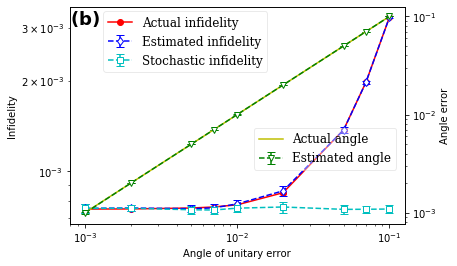

In [5]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Angle of unitary error')
ax1.set_ylabel('Infidelity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,act_uni_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle',color='g')
ax2.plot(angle_list,angle_list,'y',label='Actual angle')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

# Adding title
# Show plot
#plt.savefig()
plt.show()

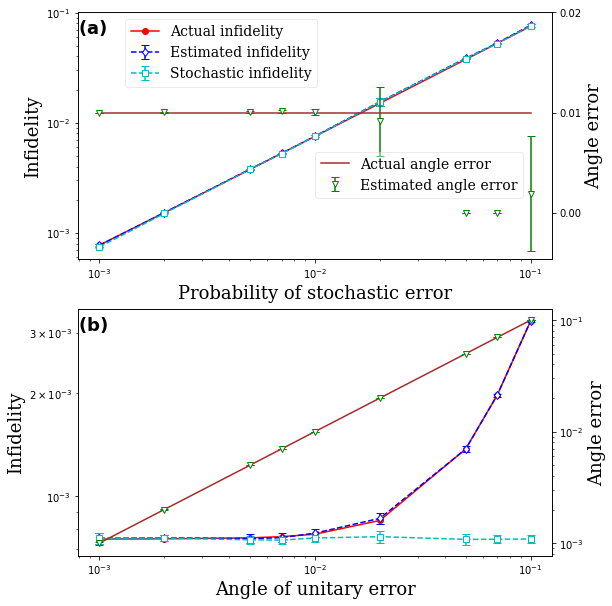

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 10)
# Creating plot with dataset_1
ax1=plt.subplot(2,1,1)
 

ax1.set_xlabel('Probability of stochastic error',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,act_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':14},fontsize=16)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[0.01 for i in range(9)],'brown',label='Actual angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle error',color='g')

ax2.set_yticks((0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.5,0.25), prop={'family':'serif', 'size':14},fontsize=16)


# Creating plot with dataset_2
ax1=plt.subplot(2,1,2)
ax1.set_xlabel('Angle of unitary error',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,act_uni_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
#ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.plot(angle_list,angle_list,'brown',label='Actual angle')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle',color='g')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
#ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

fig.subplots_adjust(hspace=0.2)
plt.savefig('csb_xg.pdf')
plt.show()

In [2]:
# simulation of ry(pi/2) gate under varying stochastic noise and fixed unitary error
ts=time()
ps_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[25 for i in range(2)]+ [9 for i in range(4)]+ [1 for i in range(3)]   
L_max_list=[100,100]+[50 for i in range(7)]   # 50 is enough, but one can increase 'L_max' further to gain more accuracy
shots=10**4
act_error_list=[]
est_sto=[]
for i,ps in enumerate(ps_list):
    noise_model,error_1q= get_noise_model(ps=ps,angle=-0.01,axis='y')
    act_error_list.append(act_error(error_1q))
    
    for k in range(10):
        csb_y2= Csb_q1rotation(rot_angle=pi/2,rot_axis='y')
        res,spec,data=csb_y2.simulation(noise_model=noise_model,len_max=L_max_list[i],shots=shots,rep=rep_list[i])
        est_sto.append(res)
te=time()
print('time cost=',te-ts)

time cost= 723.7121868133545


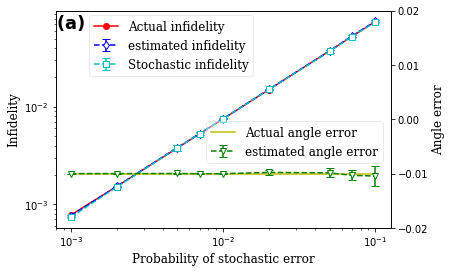

In [3]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Probability of stochastic error',fontdict={'family':'serif', 'size':12})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':12})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,act_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='estimated infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':12})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[-0.01 for i in range(9)],'y',label='Actual angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='estimated angle error',color='g')

ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.45,0.3), prop={'family':'serif', 'size':12},fontsize=12)


# Adding title
# Show plot
plt.show()

In [4]:
ts=time()
angle_list=[0.001,0.002,0.005,0.007,0.01,0.02,0.05,0.07,0.1]
rep_list=[25 for i in range(6)]+[13 for i in range(3)]  # for very weak noise, the more precision needed, which can be achieved by increasing the length of the circuits
L_max=100    # increasing length can be achieved by increasing L_max (also equal to the num of circuits) or increasing 'rep' (the num of target is repeated each time applied; if unitary noise is too strong, 'rep' should be small, otherwise may causing misidentification of eigenvalues)
shots=10**4
act_uni_error_list=[]
est_uni=[]
data_list=[]
for i,angle in enumerate(angle_list):
    noise_model,error_1q= get_noise_model(ps=0.001,angle=angle,axis='y')
    act_uni_error_list.append(act_error(error_1q))
    for k in range(10):
        csb_y2= Csb_q1rotation(rot_angle=pi/2,rot_axis='y')
        res,spec,data=csb_y2.simulation(noise_model=noise_model,len_max=L_max,shots=shots,rep=rep_list[i])
        est_uni.append(res)
        data_list.append(data)
te=time()
print('time cost=',te-ts)

time cost= 6706.874657154083


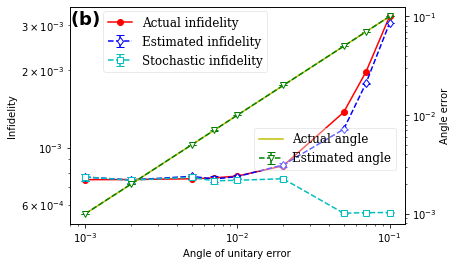

In [5]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 

ax1.set_xlabel('Angle of unitary error')
ax1.set_ylabel('Infidelity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,act_uni_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 

ax2.set_ylabel('Angle error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='--v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle',color='g')
ax2.plot(angle_list,angle_list,'y',label='Actual angle')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

# Adding title
# Show plot
#plt.savefig()
plt.show()

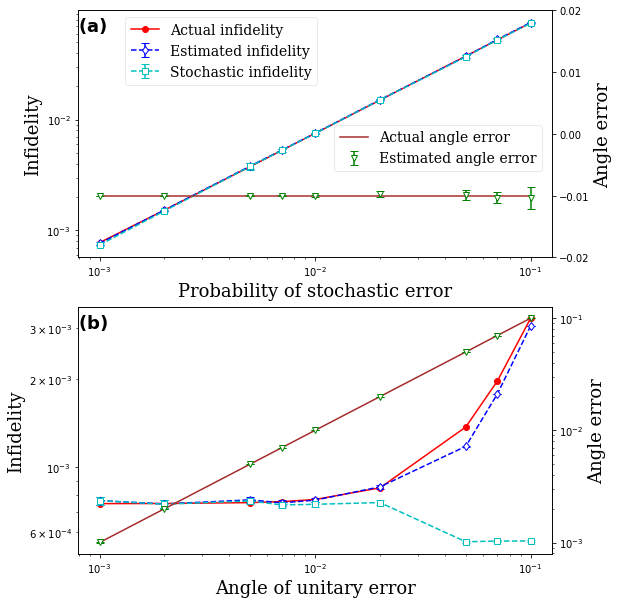

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 10)
# Creating plot with dataset_1
ax1=plt.subplot(2,1,1)
 

ax1.set_xlabel('Probability of stochastic error',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(ps_list,act_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,0],9))),list(map(np.std,np.split(np.array(est_sto)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,1],9))),list(map(np.std,np.split(np.array(est_sto)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':14},fontsize=16)
plt.title(r'$\bf(a)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()

ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(ps_list,[-0.01 for i in range(9)],'brown',label='Actual angle error')
ax2.errorbar(ps_list,list(map(np.mean,np.split(np.array(est_sto)[:,2],9))),list(map(np.std,np.split(np.array(est_sto)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle error',color='g')

ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
ax2.legend(framealpha=0.4, ncol=1, loc=(0.54,0.35), prop={'family':'serif', 'size':14},fontsize=16)


# Creating plot with dataset_2
ax1=plt.subplot(2,1,2)
ax1.set_xlabel('Angle of unitary error',fontdict={'family':'serif', 'size':18})
ax1.set_ylabel('Infidelity',fontdict={'family':'serif', 'size':18})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(angle_list,act_uni_error_list,'r',marker='o',ls='-',label='Actual infidelity')
ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,0],9))),list(map(np.std,np.split(np.array(est_uni)[:,0],9))),
             fmt='--d',markersize=6,capsize=4,markerfacecolor='white',label='Estimated infidelity',color='b')

ax1.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,1],9))),list(map(np.std,np.split(np.array(est_uni)[:,1],9))),
             fmt='--s',markersize=6,capsize=4,markerfacecolor='white',label='Stochastic infidelity',color='c')

ax1.tick_params(axis ='y')
#ax1.legend(framealpha=0.4, ncol=1, loc=(0.1,0.7), prop={'family':'serif', 'size':12},fontsize=12)
plt.title(r'$\bf(b)$',y=0.89,loc='left',fontdict={'family':'serif', 'size':18})
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
ax2.set_ylabel('Angle error',fontdict={'family':'serif', 'size':18})
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.plot(angle_list,angle_list,'brown',label='Actual angle')
ax2.errorbar(angle_list,list(map(np.mean,np.split(np.array(est_uni)[:,2],9))),list(map(np.std,np.split(np.array(est_uni)[:,2],9))),
             fmt='v',markersize=6,capsize=4,markerfacecolor='white',label='Estimated angle',color='g')

#ax2.set_yticks((-0.02,-0.01,0,0.01,0.02))
#ax2.legend(framealpha=0.4, ncol=1, loc=(0.55,0.25), prop={'family':'serif', 'size':12},fontsize=12)

fig.subplots_adjust(hspace=0.2)
plt.savefig('csb_y2g.pdf')
plt.show()